# Santo Domingo Pizza Store

## introduction
In the city of Santo Domingo the fast food bussiness, restaurants and bars are located using a criteria of comercial opportunity that may be as a sum of those business decisions be extracted and maybe measure.

This work will like to cluster those areas is similar groups and determine where will be reasonable to add a new pizza store.

#### Importing libraries

In [1183]:
import pandas as pd 
import requests 
from sklearn.cluster import KMeans
import geocoder
from pandas.io.json import json_normalize 
import folium  
import time
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from IPython.display import display, clear_output
import seaborn as sb
from matplotlib import pyplot

from folium import plugins
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math

#### Set the API KEYS

In [19]:
apikeys = pd.read_csv("../apikeys.csv").values.tolist()
GOOGLE_APIKEY = apikeys[0][1]
FOURSQUARE_CLIENT_ID = apikeys[1][1]
FOURSQUARE_CLIENT_SECRET = apikeys[2][1]
FOURSQUARE_VERSION = 20180605

print("Please set this apikeys before proceding")

Please set this apikeys before proceding


#### Importing neighborhoods from the Distrito Nacional, Santo Domingo, Dominican Republic

In [23]:
address = 'Santo Domingo, Republica Dominicana'
g = geocoder.google(address, key=GOOGLE_APIKEY )
loc = g.latlng
print(address, "location", location)



Santo Domingo, Republica Dominicana location [18.4860575, -69.93121169999999]


In [26]:
sd = pd.read_csv("sd_neighborhoods.csv")
sd.head()

,Lugar,Latitud,Longitud
0,24 de Abril,18.504887,-69.894479
1,27 de Febrero,18.464193,-69.933279
2,30 de Mayo,18.442186,-69.937912
3,Agua Dulce,18.501660,-69.883193
4,Altos de Arroyo Hondo I,18.503763,-69.950567


#### Visualizing the neighborhoods
Santo Domingo has some overlapped neighborhoods centers, either way we are looking out for walkable distance from those points, in this map we can see the range of the venues search

In [60]:
map = folium.Map(location=loc, zoom_start=12)
for index,row in sd.iterrows():
    label = '{}'.format(row.Lugar)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(  [row.Latitud, row.Longitud],  popup=label,  radius=650,  color='blue',   fill=True,   fill_color='#3186cc',   fill_opacity=0.3,    parse_html=False).add_to(map)  
map

Query the locations for venues using foursquare API

In [80]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


def get_venues(latlng):
    url = "https://api.foursquare.com/v2/venues/explore?ll={},{}&client_id={}&client_secret={}&v=20120723&limit=100&radius=650".format(latlng[0], latlng[1], FOURSQUARE_CLIENT_ID, FOURSQUARE_CLIENT_SECRET)
    fs = requests.get(url)
    try:
        return fs.json()["response"]["groups"][0]["items"]
    except:
        print("Error al hacer query a foursquare", vars(fs))
        return []


r = []
for index,row in sd.iterrows():
    clear_output(wait=True)
    latlng = row[["Latitud", "Longitud"]].values.tolist() 
    display("Query : {} de {} para las coordenadas {},{}".format( index, sd.shape[0], latlng[0], latlng[1])  )

    res = get_venues(row[["Latitud", "Longitud"]])
    
    if (len(res) == 0): continue
    rr = json_normalize(res)  
    
    rr["venue.categories"] = rr.apply(get_category_type, axis=1)
    rr["zone latitude"] = latlng[0]
    rr["zone longitude"] = latlng[1]
    rr["zone id"] = row.Lugar
    r = r + rr[['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', "zone latitude", "zone longitude", "zone id"]].values.tolist()

venues = pd.DataFrame(r, columns=["Location", "Category", "Lat", "Lng", "Zone Lat", "Zone Lng", "Zone"])
venues["CatId"] = venues.Category.astype('category').cat.codes

clear_output(wait=True)
print("shape ", venues.shape)
venues.head()

shape  (3940, 8)


,Location,Category,Lat,Lng,Zone Lat,Zone Lng,Zone,CatId
0,Supermercado Avanzado,Big Box Store,18.505426,-69.897498,18.504887,-69.894479,24 de Abril,29
1,Farmacia La Solucion,Pharmacy,18.504574,-69.896772,18.504887,-69.894479,24 de Abril,170
2,Aprezio Espaillat,Big Box Store,18.502084,-69.894591,18.504887,-69.894479,24 de Abril,29
3,Cafeteria La Milagrosa,Coffee Shop,18.507219,-69.898720,18.504887,-69.894479,24 de Abril,59
4,Wendy’s,Fast Food Restaurant,18.463924,-69.934080,18.464193,-69.933279,27 de Febrero,81


There where some weird issues with venues and the nearest zones, so i had to map by euclidean distance the final venues by zone

In [1204]:
clean_venues = venues.drop(["Zone Lat", "Zone Lng", "Zone"], axis=1).drop_duplicates()

def get_venue_distance_to(zone, venue):
    R = 6378.137 # Radius of earth in KM    
    lat1 = zone[0]
    lng1 = zone[1]
    lat2 = venue[0]
    lng2 = venue[1]
    
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180;
    dLon = lng2 * math.pi / 180 -  lng1  * math.pi / 180;
    a = math.sin(dLat/2) * math.sin(dLat/2) +  math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) *  math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c;
    return d * 1000


no = 0
r = []
for i,zone in sd.iterrows():
    clear_output(wait=True)
    print("check", zone.Lugar, i, "de", sd.shape[0])
    for i,row in clean_venues.iterrows():
        if ( abs(row.Lat-zone.Latitud) > 0.2): continue
        if ( abs(row.Lng-zone.Longitud) > 0.2): continue
        dist = get_venue_distance_to(zone[["Latitud", "Longitud"]].values.tolist(), row[["Lat", "Lng"]])
        if (dist < 650):
            no = no +1
            r.append([zone.Lugar, zone.Latitud, zone.Longitud]+row[["Location", "Category", "Lat", "Lng", "CatId"]].values.tolist())
            
print("total itemes added", no)
ajusted_venues = pd.DataFrame(r, columns=["Zone", "Zone Lat", "Zone Lng", "Location", "Category", "Lat", "Lng", "CatId"])
ajusted_venues.head()

check Zona Universitaria 147 de 148
total itemes added 4589


,Zone,Zone Lat,Zone Lng,Location,Category,Lat,Lng,CatId
0,24 de Abril,18.504887,-69.894479,Supermercado Avanzado,Big Box Store,18.505426,-69.897498,29
1,24 de Abril,18.504887,-69.894479,Farmacia La Solucion,Pharmacy,18.504574,-69.896772,170
2,24 de Abril,18.504887,-69.894479,Aprezio Espaillat,Big Box Store,18.502084,-69.894591,29
3,24 de Abril,18.504887,-69.894479,Cafeteria La Milagrosa,Coffee Shop,18.507219,-69.898720,59
4,24 de Abril,18.504887,-69.894479,Helados Bon,Ice Cream Shop,18.502810,-69.897289,117


In [1208]:
venues = ajusted_venues

Venues mapped by category

In [1207]:
colors_array = cm.rainbow(np.linspace(0, 1, len(venues.Category.unique()) ))
rainbow = [colors.rgb2hex(i) for i in colors_array]


map = folium.Map(location=loc, zoom_start=12)
for index,row in ajusted_venues[["Location","Category","Lat","Lng","CatId"]].drop_duplicates().iterrows():
    label = '{}, {}'.format(row.Location, row.Category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row.Lat, row.Lng],  popup=label,  radius=4,  color=rainbow[row.CatId-1],   fill=True,   fill_color=rainbow[row.CatId-1],   fill_opacity=0.7,    parse_html=False).add_to(map)  

map

### Transforming the venues dataset

In [1209]:
data = pd.get_dummies(venues.drop(["Location", "CatId", "Lat", "Lng", "Zone"], axis=1), prefix="", prefix_sep="")
data["Zone"] = venues["Zone"]
group = data.groupby("Zone")
data = data.groupby("Zone").mean().reset_index()
data["Densidad"] = group["Zone Lat"].count().reset_index().loc[:, "Zone Lat"]
for i,row in data.iterrows():
    if (row.Densidad < 8): data.loc[i, "Densidad"] = "LOW"
    elif (row.Densidad < 20): data.loc[i, "Densidad"] = "LOW MID"
    elif (row.Densidad < 50): data.loc[i, "Densidad"] = "MID"
    else: data.loc[i, "Densidad"] = "HIGH"
venues_by_zone = data

venues_by_zone = venues_by_zone.join(pd.get_dummies(venues_by_zone[["Densidad"]], prefix="Density", prefix_sep=" ")).drop(["Densidad"], axis=1)
print("SHAPE: ", venues_by_zone.shape)
venues_by_zone.head(10)

SHAPE:  (145, 238)


,Zone,Zone Lat,Zone Lng,Accessories Store,Airport,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Density HIGH,Density LOW,Density LOW MID,Density MID
0,24 de Abril,18.504887,-69.894479,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0
1,27 de Febrero,18.464193,-69.933279,0.0,0.0,0.010204,0.010204,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0,0
2,30 de Mayo,18.442186,-69.937912,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,1
3,Agua Dulce,18.501660,-69.883193,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0
4,Altos de Arroyo Hondo I,18.503763,-69.950567,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,1,0
5,Altos de Arroyo Hondo II,18.503763,-69.950567,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,1,0
6,Altos de Arroyo Hondo III,18.505397,-69.965456,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0
7,Antillas,18.486058,-69.931212,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.0,0.0,1,0,0,0
8,Arboleda (naco),18.475358,-69.926794,0.0,0.0,0.008333,0.008333,0.008333,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0,0
9,Arroyo Manzano,18.520969,-69.962695,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0,0


### Clustering the Neighborhoods by venues composition and Density

In [1210]:
kclusters = 10

grouped_clustering = venues_by_zone.drop(['Zone', 'Zone Lat', 'Zone Lng'], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1)
k_result = kmeans.fit(grouped_clustering)

nn_ = venues_by_zone.copy()
nn_.insert(0, 'Cluster', k_result.labels_)
clustered_venues = nn_
clustered_venues.head()


,Cluster,Zone,Zone Lat,Zone Lng,Accessories Store,Airport,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Density HIGH,Density LOW,Density LOW MID,Density MID
0,4,24 de Abril,18.504887,-69.894479,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,1,27 de Febrero,18.464193,-69.933279,0.0,0.0,0.010204,0.010204,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,2,30 de Mayo,18.442186,-69.937912,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,4,Agua Dulce,18.501660,-69.883193,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
4,3,Altos de Arroyo Hondo I,18.503763,-69.950567,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0


In [1211]:
colors_array = cm.rainbow(np.linspace(0, 1, len(clustered_venues.Cluster.unique()) ))
rainbow = [colors.rgb2hex(i) for i in colors_array]


map = folium.Map(location=loc, zoom_start=12)
for index,row in clustered_venues.iterrows():
    label = '{}, {}'.format(row.Zone, row.Cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=8,  color=rainbow[row.Cluster-1],   fill=True,   fill_color=rainbow[row.Cluster-1],   fill_opacity=0.7,    parse_html=False).add_to(map)  

map


#### Top 10 venues categories by zone

In [1323]:
top_limit = 10
r = []
for i,row in clustered_venues.iterrows():
    row_categories = row.iloc[4:-4].sort_values(ascending=False)   
    r.append([row.Cluster, row.Zone]+row_categories[0:top_limit].index.tolist() + [row["Density LOW"], row["Density LOW MID"], row["Density MID"], row["Density HIGH"]])


top = pd.DataFrame(r, columns=["Cluster", "Zona", "1er", "2do", "3er", "4to", "5to", "6to", "7mo", "8vo", "9no", "10mo", "Density LOW", "Density LOW MID", "Density MID", "Density HIGH"]).sort_values("Cluster")
top.head(30)



,Cluster,Zona,1er,2do,3er,4to,5to,6to,7mo,8vo,9no,10mo,Density LOW,Density LOW MID,Density MID,Density HIGH
79,0,La Meseta,Gym / Fitness Center,Zoo,Dessert Shop,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,Empanada Restaurant,1,0,0,0
72,1,La Cementera,Italian Restaurant,Sushi Restaurant,Mediterranean Restaurant,Restaurant,Ice Cream Shop,Shopping Mall,Food Truck,Fast Food Restaurant,Bar,Bakery,0,0,0,1
112,1,Paraiso,Clothing Store,Ice Cream Shop,Bar,Bakery,Asian Restaurant,Sandwich Place,Bistro,Flower Shop,Shopping Mall,Karaoke Bar,0,0,0,1
26,1,Ciudad Nueva,Bar,Hotel,Spanish Restaurant,Gay Bar,Café,Pizza Place,BBQ Joint,Karaoke Bar,Plaza,Pharmacy,0,0,0,1
54,1,Ensanche Lugo,Pizza Place,Spanish Restaurant,Chinese Restaurant,Gay Bar,Pharmacy,Caribbean Restaurant,Bank,Karaoke Bar,Park,Plaza,0,0,0,1
111,1,Naco,Restaurant,Bar,Sushi Restaurant,Italian Restaurant,Food Truck,Ice Cream Shop,Pizza Place,Bakery,Sandwich Place,Mediterranean Restaurant,0,0,0,1
109,1,Mirador Norte,Pizza Place,Sandwich Place,Bar,BBQ Joint,Fast Food Restaurant,Food Truck,Ice Cream Shop,Fried Chicken Joint,Vegetarian / Vegan Restaurant,Hot Dog Joint,0,0,0,1
89,1,Lopez de Vega,Mediterranean Restaurant,Italian Restaurant,Restaurant,Sushi Restaurant,Bistro,Lounge,Shopping Mall,Bakery,Food Truck,Asian Restaurant,0,0,0,1
87,1,Las Villas,Clothing Store,Sandwich Place,Ice Cream Shop,Tennis Court,Asian Restaurant,Fast Food Restaurant,Bakery,Restaurant,Department Store,Shopping Mall,0,0,0,1
86,1,Las Flores,Bar,Ice Cream Shop,Sushi Restaurant,Restaurant,Italian Restaurant,Food Truck,Mediterranean Restaurant,Pizza Place,Spanish Restaurant,Supermarket,0,0,0,1


57121 (145, 239) 57121 (145, 239)


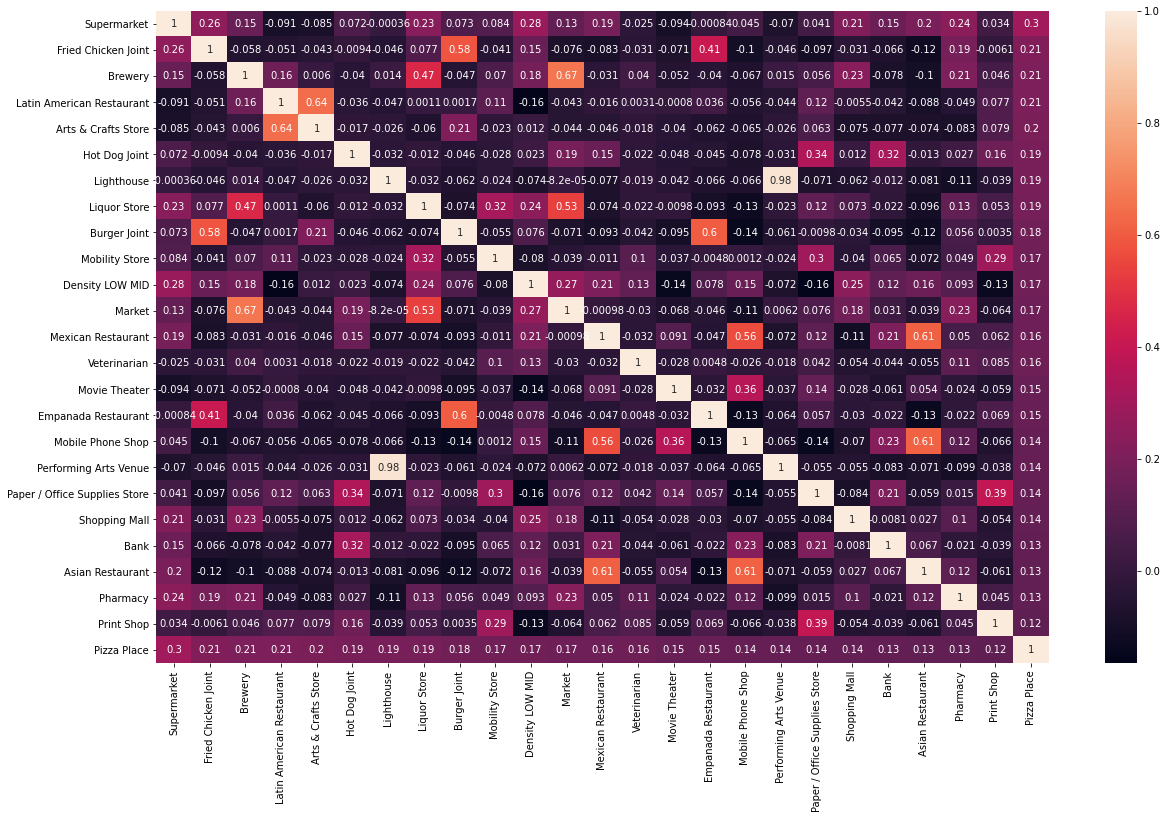

In [1332]:
fig, ax = pyplot.subplots(figsize=(20, 12) )

sorted = venues.groupby("Category").count().reset_index()[["Category", "Location"]].sort_values("Location", ascending=False)   
sorted = sorted[sorted.Location<50]
sorted.shape

most_coorelated = clustered_venues.corr()["Pizza Place"].sort_values(ascending=False).iloc[1:25].index.tolist()

nn = clustered_venues
sb.heatmap(ax=ax, data=nn[most_coorelated+["Pizza Place"]].corr(), annot=True,)
#ax = sb.heatmap(ax=ax, data=nn.drop(["Zone", "Zone Lat", "Zone Lng"], axis=1).corr(), annot=True,)
print (nn.shape[1]*nn.shape[1],  nn.shape, clustered_venues.shape[1]*clustered_venues.shape[1], clustered_venues.shape)


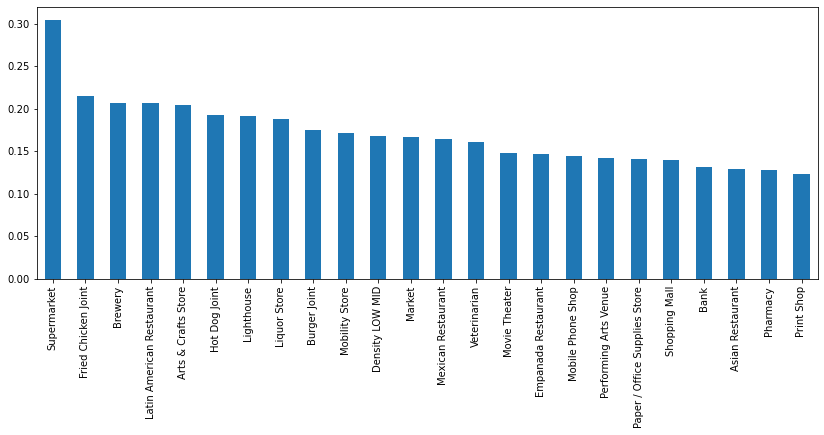

In [1259]:
c = clustered_venues.corr()
fig, ax = pyplot.subplots(figsize=(14, 5) )
c["Pizza Place"].sort_values(ascending=False).iloc[1:25].plot(ax = ax, kind="bar")

So, performing arts places are common near Pizza stores...

In [1260]:
venues[venues["Category"] == "Performing Arts Venue"]

,Zone,Zone Lat,Zone Lng,Location,Category,Lat,Lng,CatId
326,Arboleda (naco),18.475358,-69.926794,XMT Academy,Performing Arts Venue,18.472184,-69.923200,166
677,Cerros de Arroyo Hondo,18.510254,-69.943726,La Casita de Producciones,Performing Arts Venue,18.510782,-69.942470,166
893,Cuesta Hermosa,18.511279,-69.941634,La Casita de Producciones,Performing Arts Venue,18.510782,-69.942470,166
895,Cuesta Hermosa III,18.511279,-69.941634,La Casita de Producciones,Performing Arts Venue,18.510782,-69.942470,166
1443,Esperilla,18.467962,-69.922466,XMT Academy,Performing Arts Venue,18.472184,-69.923200,166
2182,La Primavera,18.467045,-69.899944,Salon La Fiesta - Renaissance Santo Domingo Ja...,Performing Arts Venue,18.461743,-69.900405,166
2191,La Puya,18.507329,-69.937912,La Casita de Producciones,Performing Arts Venue,18.510782,-69.942470,166
2268,La Yuca,18.468951,-69.927769,XMT Academy,Performing Arts Venue,18.472184,-69.923200,166
2448,Las Flores,18.475536,-69.925378,XMT Academy,Performing Arts Venue,18.472184,-69.923200,166
3124,Naco,18.475358,-69.926794,XMT Academy,Performing Arts Venue,18.472184,-69.923200,166


## Using random forest to predict where is a pizza place

In [1261]:
ds = clustered_venues.copy()
for index,row in ds.iterrows():
    if (row["Pizza Place"] != 0): ds.loc[index, "Pizza Place"] = 1
    else :  ds.loc[index, "Pizza Place"]  = 0


X_train, X_test, y_train, y_test = train_test_split( ds.drop(["Cluster", "Pizza Place", "Zone", "Zone Lat", "Zone Lng"], axis=1), ds["Pizza Place"], test_size=0.33, random_state=42)
X_train.head()

,Accessories Store,Airport,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Density HIGH,Density LOW,Density LOW MID,Density MID
24,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
25,0.0,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
23,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
80,0.0,0.000000,0.022222,0.0,0.0,0.0,0.0,0.0,0.000000,0.022222,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
68,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0


In [1262]:
index = 7
last_score = 0

for i in range(7, 18):
    regr = RandomForestClassifier(max_depth=i, random_state=0, n_estimators=60)
    regr.fit(X_train, y_train)
    score = regr.score(X_test, y_test)
    if( score > last_score):
        last_score = score
        index = i
print("DEEP SELECTED", index, last_score)


regr = RandomForestClassifier(max_depth=index, random_state=0, n_estimators=60)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

DEEP SELECTED 7 0.8958333333333334


0.8958333333333334

In [1263]:
feature_scores = pd.Series(regr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores.iloc[0:10]

Pharmacy                         0.071403
Density LOW                      0.068707
Fast Food Restaurant             0.032578
Ice Cream Shop                   0.026528
Gym / Fitness Center             0.026197
Supermarket                      0.024962
Paper / Office Supplies Store    0.022886
Asian Restaurant                 0.022338
Food Truck                       0.021037
Department Store                 0.020446
dtype: float64

In [1219]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
y_pred = regr.predict(X_test)
print(len(X_test))
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

48
0.8958333333333334
0.9615384615384616
[[18  4]
 [ 1 25]]


#### Visualizing predictions
1. Blue: its predicted it **SHOULD** be a pizza place here, and was found it does **EXIST**
2. GREEN: its predicted it **SHOULD** be a pizza place here, and was found it does **NOT EXIST**
3. RED: its predicted it **SHOULD NOT** be a pizza place here, and was found it does **EXIST**

In [1220]:
sites = ds.copy()
y_pred = regr.predict(ds[X_train.columns])
sites["PREDICTION PIZZA PLACE"] = y_pred


map = folium.Map(location=loc, zoom_start=12)
for index,row in sites.iterrows():
    label = '{}, predicted: {}, found: {}'.format(row.Zone, row["PREDICTION PIZZA PLACE"]==1, row["Pizza Place"]==1)
    label = folium.Popup(label, parse_html=True)
    color = "blue"
    if (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] ==0): color = "red"
    elif (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] == 1): color = "green"
    folium.CircleMarker(
        [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=12,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.7,    parse_html=False).add_to(map)  
    
map

## Test de prediction model agains a new location (Santiago de los Caballeros)
I will test the model against a dataset of Santiago City venues, on the north of Dominican Republic.
First we need to get the city location

In [394]:
address = 'Santiago, Republica Dominicana'
g = geocoder.google(address, key=GOOGLE_APIKEY )
loc_stgo = g.latlng
print(address, "location", loc_stgo)

Santiago, Republica Dominicana location [19.4791963, -70.6930568]


Loading neighborhoods of Santiago de los Caballeros dataset

In [1089]:
sgo = pd.read_csv("sgo_neighborhoods.csv")
sgo.head()

,Lugar,Latitud,Longitud
0,Altos de Rafey,19.468606,-70.727680
1,Altos de Virella,19.485341,-70.720410
2,La Arboleda,19.422972,-70.682631
3,El Área Monumental,19.452031,-70.694850
4,Arroyo Hondo Abajo,19.426491,-70.699748


Load venues by latitude and longitude using foursquare API.

In [1088]:
r = []
for index,row in sgo.iterrows():
    clear_output(wait=True)
    latlng = row[["Latitud", "Longitud"]].values.tolist() 
    display("Query : {} de {} para las coordenadas {},{}".format( index, sgo.shape[0], latlng[0], latlng[1])  )

    res = get_venues(row[["Latitud", "Longitud"]])
    
    if (len(res) == 0): continue
    rr = json_normalize(res)  
    
    rr["venue.categories"] = rr.apply(get_category_type, axis=1)
    rr["zone latitude"] = latlng[0]
    rr["zone longitude"] = latlng[1]
    rr["zone id"] = row.Lugar
    r = r + rr[['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', "zone latitude", "zone longitude", "zone id"]].values.tolist()

venues_sgo = pd.DataFrame(r, columns=["Location", "Category", "Lat", "Lng", "Zone Lat", "Zone Lng", "Zone"])
venues_sgo["CatId"] = venues_sgo.Category.astype('category').cat.codes

clear_output(wait=True)
print("shape ", venues_sgo.shape)
venues_sgo.head()

shape  (600, 8)


,Location,Category,Lat,Lng,Zone Lat,Zone Lng,Zone,CatId
0,Play Coraasan,Stadium,19.466501,-70.725202,19.468606,-70.72768,Altos de Rafey,111
1,Rafa Pollo,Food Truck,19.471779,-70.729105,19.468606,-70.72768,Altos de Rafey,49
2,Tipico Monte Bar,Bar,19.481970,-70.718490,19.485341,-70.72041,Altos de Virella,10
3,Domino's Pizza,Pizza Place,19.481217,-70.718907,19.485341,-70.72041,Altos de Virella,93
4,Farmacia Yna,Pharmacy,19.486715,-70.718762,19.485341,-70.72041,Altos de Virella,91


#### Transforming venues data for Santiago City

In [400]:
data = pd.get_dummies(venues_sgo.drop(["Location", "CatId", "Lat", "Lng", "Zone"], axis=1), prefix="", prefix_sep="")
data["Zone"] = venues_sgo["Zone"]
group = data.groupby("Zone")
data = data.groupby("Zone").mean().reset_index()
data["Densidad"] = group["Zone Lat"].count().reset_index().loc[:, "Zone Lat"]
for i,row in data.iterrows():
    if (row.Densidad < 8): data.loc[i, "Densidad"] = "LOW"
    elif (row.Densidad < 20): data.loc[i, "Densidad"] = "LOW MID"
    elif (row.Densidad < 50): data.loc[i, "Densidad"] = "MID"
    else: data.loc[i, "Densidad"] = "HIGH"
venues_by_zone_sgo = data

venues_by_zone_sgo = venues_by_zone_sgo.join(pd.get_dummies(venues_by_zone_sgo[["Densidad"]], prefix="Density", prefix_sep=" ")).drop(["Densidad"], axis=1)
print("SHAPE: ", venues_by_zone_sgo.shape)
venues_by_zone_sgo.head()

SHAPE:  (54, 130)


,Zone,Zone Lat,Zone Lng,Airport,American Restaurant,Arepa Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Toy / Game Store,Trail,Tree,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Wings Joint,Density LOW,Density LOW MID,Density MID
0,Altos de Rafey,19.468606,-70.727680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,Altos de Virella,19.485341,-70.720410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,Baracoa,19.458070,-70.709327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,Bella Vista,19.445367,-70.709413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,Buena Vista,19.475794,-70.689900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


#### Normalizing the venues dataset
Santiago's venues have a different category composition than those on Santo Domingo, a good way to solve it could be by clustering all the venues Categories on a simpler set of features. This is not covered on this notebook, so is a need to remove all the features not present on the Santo Domingo study, and fill those that are not present on Santiago's one with zeros

In [821]:
present_columns_on_santiago = venues_by_zone.columns[(venues_by_zone.columns.isin(venues_by_zone_sgo.columns))]
not_present_columns_on_santiago = venues_by_zone.columns[~(venues_by_zone.columns.isin(venues_by_zone_sgo.columns))]
data = venues_by_zone_sgo[present_columns_on_santiago].copy()
for col in not_present_columns_on_santiago:
    data[col] = 0

venues_by_zone_sgo_normalized = data
[data.shape, venues_by_zone.shape, venues_by_zone_sgo.shape]


[(54, 238), (144, 238), (54, 130)]

### Clustering 
The same kmean built for the city of Santo Domingo, is again used to predict the neighborhoods clusters for the Santiago City

In [1090]:
kclusters = 10

grouped_clustering_sgo = venues_by_zone_sgo_normalized.drop(['Zone', 'Zone Lat', 'Zone Lng'], 1)
k_results = kmeans.predict(grouped_clustering_sgo)

nn_ = venues_by_zone_sgo_normalized.copy()
nn_.insert(0, 'Cluster', k_results)
clustered_venues_sgo = nn_
clustered_venues_sgo.sort_values("Density MID", ascending=False).head()
clustered_venues_sgo.head()

,Cluster,Zone,Zone Lat,Zone Lng,Airport,American Restaurant,Arepa Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theme Restaurant,Venezuelan Restaurant,Veterinarian,Waterfront,Whisky Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Density HIGH
0,0,Altos de Rafey,19.468606,-70.727680,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3,Altos de Virella,19.485341,-70.720410,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,Baracoa,19.458070,-70.709327,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,Bella Vista,19.445367,-70.709413,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,Buena Vista,19.475794,-70.689900,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1091]:
#Reusing KMEAN

colors_array = cm.rainbow(np.linspace(0, 1, len(clustered_venues.Cluster.unique()) ))
rainbow = [colors.rgb2hex(i) for i in colors_array]


map = folium.Map(location=loc_stgo, zoom_start=12)
for index,row in clustered_venues_sgo.iterrows():
    label = '{}, {}'.format(row.Zone, row.Cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=8,  color=rainbow[row.Cluster-1],   fill=True,   fill_color=rainbow[row.Cluster-1],   fill_opacity=0.7,    parse_html=False).add_to(map)  

map

#### Testing the Random Forest Model Against Santiago City

54
0.7962962962962963
0.65
[[30  4]
 [ 7 13]]


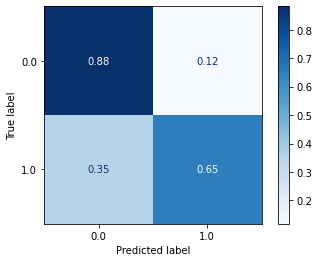

In [1136]:
ds_sgo = clustered_venues_sgo[clustered_venues.columns.values.tolist()].copy()

for index, row in ds_sgo.iterrows():
    if (row["Pizza Place"] != 0): ds_sgo.loc[index, "Pizza Place"] = 1
    else: ds_sgo.loc[index, "Pizza Place"] = 0

X = ds_sgo[X_train.columns.values.tolist()]
y = ds_sgo["Pizza Place"]
regr.score(X, y)

y_pred = regr.predict(X)

print(len(X))
print(accuracy_score(y,y_pred))
print(recall_score(y,y_pred))
print(confusion_matrix(y,y_pred))
plot_confusion_matrix(regr, X, y, cmap=plt.cm.Blues, normalize="true")


As we can see we have 35% of the negatives were truth, lets see where are those cases, some of the cases where near Universities and Parks

In [1122]:
sites = ds_sgo.copy()
y_pred = regr.predict(X)
sites["PREDICTION PIZZA PLACE"] = y_pred
sites.head()


map = folium.Map(location=loc_stgo, zoom_start=12)
for index,row in sites.iterrows():
    label = '{}, predicted: {}, found: {}'.format(row.Zone, row["PREDICTION PIZZA PLACE"]==1, row["Pizza Place"]==1)
    label = folium.Popup(label, parse_html=True)
    color = "blue"
    if (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] ==0): color = "red"
    elif (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] == 1): color = "green"
    folium.CircleMarker(
        [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=12,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.7,    parse_html=False).add_to(map)  


map

In [1137]:
top_limit = 10
r = []
for i,row in ds_sgo.iterrows():
    row_categories = row.iloc[4:-4].sort_values(ascending=False)   
    r.append([row.Cluster, row.Zone]+row_categories[0:top_limit].index.tolist() + [row["Density LOW"], row["Density LOW MID"], row["Density MID"], row["Density HIGH"]])


top = pd.DataFrame(r, columns=["Cluster", "Zona", "1er", "2do", "3er", "4to", "5to", "6to", "7mo", "8vo", "9no", "10mo", "Density LOW", "Density LOW MID", "Density MID", "Density HIGH"]).sort_values("Cluster")
top.head(3)

,Cluster,Zona,1er,2do,3er,4to,5to,6to,7mo,8vo,9no,10mo,Density LOW,Density LOW MID,Density MID,Density HIGH
0,0,Altos de Rafey,Food Truck,Stadium,Zoo,Food & Drink Shop,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,1,0,0,0
22,0,La Arboleda,Caribbean Restaurant,Fried Chicken Joint,Convenience Store,Paintball Field,Sandwich Place,Zoo,Dim Sum Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,1,0,0,0
23,0,La Joya,Food,Nightclub,Gas Station,Theater,Bar,Basketball Court,Farmers Market,Fast Food Restaurant,Cocktail Bar,Falafel Restaurant,0,1,0,0


## Refiting Random Forest Classifier Model

In [1314]:
X2train, X2test, y2train, y2test = train_test_split( X, y, test_size=0.30, random_state=42)


def get_idea_fit():
    deep = 0
    last_score = 0
    estimators = 0
    
    for i in range(5,10):
        for est in range(4,10):
            clear_output(wait=True)
            regr2 = RandomForestClassifier(max_depth=i, random_state=0, n_estimators=est*10, warm_start=True, oob_score=True)
            regr2.fit(X_train, y_train)
            
            regr2.set_params(n_estimators=est*10*2)
            regr2.fit(X2train, y2train)
            score = ((regr2.score(X2train, y2train)*X2train.shape[0] + regr2.score(X_train, y_train)*X_train.shape[0] )) / (X_train.shape[0]+X2train.shape[0])
            
            print("Con deep", i, ", estimadores", est*10, ", el score", score, "::: ", last_score)
            if (score > last_score):
                last_score = score
                deep = i
                estimators = est*10
    return [deep, last_score, estimators]
      


ops = get_idea_fit()
print("Selected max depp:", ops[0], "estimators:", ops[2], "score", ops[1])
regr2 = RandomForestClassifier(max_depth=ops[0], random_state=0, n_estimators=ops[2], warm_start=True, oob_score=True)
regr2.fit(X_train, y_train)


regr2.set_params(n_estimators=ops[2]*2)
regr2.fit(X2train, y2train)

regr2.score(X2test, y2test)

Con deep 9 , estimadores 90 , el score 0.9477611940298507 :::  0.9477611940298507
Selected max depp: 7 estimators: 40 score 0.9477611940298507


0.9411764705882353

Now test Santo Domingo against the new model

In [1315]:
print("Santo Domingo score:", regr2.score(X_test, y_test), "Santiago Score", regr2.score(X2test, y2test))

Santo Domingo score: 0.875 Santiago Score 0.9411764705882353


In [1316]:
data = pd.DataFrame(ds[X.columns].values.tolist() + ds_sgo.values.tolist(), columns=ds_sgo.columns.values.tolist()).fillna(0)
X2train, X2test, y2train, y2test = train_test_split( data[X_train.columns.values.tolist()], data["Pizza Place"].astype(int), test_size=0.30, random_state=42)
regr2.score(X2test, y2test)

0.9666666666666667

#### New Model

199
0.964824120603015
0.75
[[177   2]
 [  5  15]]


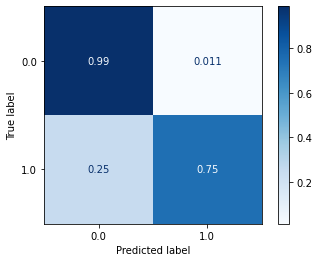

In [1317]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

XT = data[X_train.columns.values.tolist()]
YT = data["Pizza Place"].astype(int)

y_pred = regr2.predict(XT)
print(len(XT))
print(accuracy_score(YT,y_pred))
print(recall_score(YT,y_pred))
print(confusion_matrix(YT,y_pred))
plot_confusion_matrix(regr2, XT, YT, cmap=plt.cm.Blues, normalize="true")

#### Old Model

198
0.9343434343434344
0.65
[[172   6]
 [  7  13]]


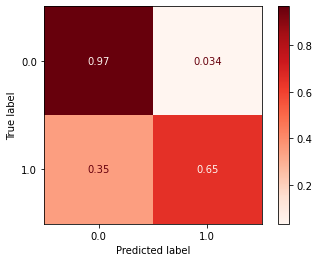

In [1144]:
y_pred = regr.predict(XT)
print(len(XT))
print(accuracy_score(YT,y_pred))
print(recall_score(YT,y_pred))
print(confusion_matrix(YT,y_pred))
plot_confusion_matrix(regr, XT, YT, cmap=plt.cm.Reds, normalize="true")

## Some recomendations for new Pizza Stores in Santo Domingo

In [1305]:
predictions_santo_domingo = ds.copy()
y_pred = regr2.predict(ds[X_train.columns])
predictions_santo_domingo["PREDICTION PIZZA PLACE"] = y_pred

new_stores = predictions_santo_domingo[ (predictions_santo_domingo["PREDICTION PIZZA PLACE"] != predictions_santo_domingo["Pizza Place"]) & (predictions_santo_domingo["PREDICTION PIZZA PLACE"] ==1) ]
print("Recomended neighborhoods on Santo Domingo for a new Pizza Place")
new_stores[["Cluster","Zone","Zone Lat","Zone Lng"]].rename(columns={"Zone": "Lugar", "Zone Lat": "Latitud", "Zone Lng": "Longitud"})

Recomended neighborhoods on Santo Domingo for a new Pizza Place


,Cluster,Lugar,Latitud,Longitud
10,2,Atala,18.445447,-69.941831
24,3,Ciudad Gandera,18.437067,-69.941984
46,2,El Portal,18.444241,-69.940517
57,1,Esperilla,18.467962,-69.922466
98,2,Los Praditos,18.469145,-69.951312
101,3,Los Restauradores,18.454598,-69.967681
114,1,Piantini,18.474953,-69.935572


In [1306]:
predictions_santiago = ds_sgo.copy()
y_pred = regr.predict(X)
predictions_santiago["PREDICTION PIZZA PLACE"] = y_pred

new_stores = predictions_santiago[ (predictions_santiago["PREDICTION PIZZA PLACE"] != predictions_santiago["Pizza Place"]) & (predictions_santiago["PREDICTION PIZZA PLACE"] ==1) ]
print("Recomended neighborhoods on Santiago for a new Pizza Place")
new_stores[["Cluster","Zone","Zone Lat","Zone Lng"]].rename(columns={"Zone": "Lugar", "Zone Lat": "Latitud", "Zone Lng": "Longitud"})

Recomended neighborhoods on Santiago for a new Pizza Place


,Cluster,Lugar,Latitud,Longitud
14,3,Ensanche Bermúdez,19.472235,-70.717219
21,3,Jardines del Este,19.446790,-70.664061
27,3,La Zurza,19.444731,-70.690951
41,3,Parque Metropolitano de Santiago,19.466470,-70.693941
47,3,Reparto Universitario,19.446131,-70.677944


## Maps

In [1290]:
sites = predictions_santo_domingo

map = folium.Map(location=loc, zoom_start=12)
for index,row in sites[sites["PREDICTION PIZZA PLACE"] == 1].iterrows():
    label = '{}, predicted: {}, found: {}'.format(row.Zone, row["PREDICTION PIZZA PLACE"]==1, row["Pizza Place"]==1)
    label = folium.Popup(label, parse_html=True)
    color = "blue"
    if (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] ==0): color = "red"
    elif (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] == 1): color = "blue"
    else: continue
    folium.CircleMarker( [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=16,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.8,    parse_html=False).add_to(map)  
    
for index,row in venues[venues["Category"] == "Pizza Place"].iterrows():
    label = '{}, {}, {}'.format(row.Location, row.Category, row.Zone)
    label = folium.Popup(label, parse_html=True)
    color = "#22CC00"
    folium.CircleMarker(
        [row.Lat, row.Lng],  popup=label,  radius=6,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.6,    parse_html=False).add_to(map)  
    
    
map


In [1309]:
sites = predictions_santiago



map = folium.Map(location=loc_stgo, zoom_start=14)
for index,row in sites[sites["PREDICTION PIZZA PLACE"] == 1].iterrows():
    label = '{}, predicted: {}, found: {}'.format(row.Zone, row["PREDICTION PIZZA PLACE"]==1, row["Pizza Place"]==1)
    label = folium.Popup(label, parse_html=True)
    color = "blue"
    if (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] ==0): color = "red"
    elif (row["PREDICTION PIZZA PLACE"] != row["Pizza Place"] and row["PREDICTION PIZZA PLACE"] == 1): color = "green"
    else: continue
    folium.CircleMarker( [row["Zone Lat"], row["Zone Lng"]],  popup=label,  radius=12,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.7,    parse_html=False).add_to(map)  
    
for index,row in venues_sgo[venues_sgo["Category"] == "Pizza Place"].iterrows():
    label = '{}, {}, {}'.format(row.Location, row.Category, row.Zone)
    label = folium.Popup(label, parse_html=True)
    color = "blue"
    folium.CircleMarker(
        [row.Lat, row.Lng],  popup=label,  radius=6,  color="#00000000",   fill=True,   fill_color=color,   fill_opacity=0.9,    parse_html=False).add_to(map)      
    
map
